## Imports

In [298]:
import pandas as pd
import seaborn as sns
import numpy
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

## Loading data

In [299]:
new_test_y = pd.read_table('/media/storage/TG/data_compare/new_data/y/fold_0_test.tsv')
new_train_y = pd.read_table('/media/storage/TG/data_compare/new_data/y/fold_0_train.tsv')
new_val_y = pd.read_table('/media/storage/TG/data_compare/new_data/y/fold_0_val.tsv')

new_test_x = pd.read_table('/media/storage/TG/data_compare/new_data/x/fold_0_test_projections.csv.eigenvec.sscore')
new_train_x = pd.read_table('/media/storage/TG/data_compare/new_data/x/fold_0_train_projections.csv.eigenvec.sscore')
new_val_x = pd.read_table('/media/storage/TG/data_compare/new_data/x/fold_0_val_projections.csv.eigenvec.sscore')

samples = pd.read_table('/media/storage/TG/data_compare/new_data/samples.tsv')

## Preparing data like in the main code

In [300]:
# Loading into pandas
y = pd.concat([new_val_y, new_test_y, new_train_y]).rename_axis('index').reset_index()
x = pd.concat([new_val_x, new_test_x, new_train_x]).rename(columns={'#IID': 'IID'}).set_index('IID').filter(regex='^PC*').reindex(y.set_index('IID').index)

# Converting into numpy
_, y_np = numpy.unique(y.iloc[:, -1].values.astype(numpy.ndarray), return_inverse=True)
x_np = x.values

# Getting numbers -> population dict
y['numbers'] = y_np.tolist()
y_nums = y.drop_duplicates(subset = ["ancestry"])
pop_dict = dict(zip(y_nums.numbers, y_nums.ancestry))

# Creating lists wich include only suspicious samples and without them
samples_index = y[y['IID'].isin(samples.IID)].index.values
samples_inverse = y[~y['IID'].isin(samples.IID)]

## Defining model

In [301]:
model = RandomForestClassifier(min_samples_leaf=1,
                               n_estimators=100)

### Quick test

In [302]:
scores = cross_validate(model, x_np, y_np, cv=10, return_train_score=True)
print(f'Train accuracies: {scores["train_score"]}\n'
      f'Test accuracies: {scores["test_score"]}')

Train accuracies: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test accuracies: [0.8973384  0.88212928 0.90494297 0.91634981 0.90076336 0.90458015
 0.95038168 0.91221374 0.91603053 0.94274809]


## Plot function

In [303]:
TG_SUPERPOP_DICT = {'ACB': 'AFR', 'ASW': 'AFR', 'ESN': 'AFR', 'GWD': 'AFR', 'LWK': 'AFR', 'MSL': 'AFR', 'YRI': 'AFR', 'CLM': 'AMR', 'MXL': 'AMR', 'PEL': 'AMR', 'PUR': 'AMR', 'CDX': 'EAS', 'CHB': 'EAS', 'CHS': 'EAS', 'JPT': 'EAS', 'KHV': 'EAS', 'CEU': 'EUR', 'FIN': 'EUR', 'GBR': 'EUR', 'IBS': 'EUR', 'TSI': 'EUR', 'BEB': 'SAS', 'GIH': 'SAS', 'ITU': 'SAS', 'PJL': 'SAS', 'STU': 'SAS'}

In [304]:
def make_confusion_matrix(cf_matrix):
    axis = []
    for i in range(len(pop_dict)):
        axis.append(pop_dict[i])
    df = pd.DataFrame(cf_matrix, index = axis, columns = axis)
    df_super = df.rename_axis('index').reset_index().replace({"index": TG_SUPERPOP_DICT}).set_index("index")
    df_super = df_super.rename_axis('index').reset_index().groupby('index').sum()
    df_super = df_super.T.rename_axis('index').reset_index().replace({"index": TG_SUPERPOP_DICT}).set_index("index")
    df_super = df_super.rename_axis('index').reset_index().groupby('index').sum().T

    labels = df.applymap(lambda v: str(v) if v > 0 else '')
    labels_super = df_super.applymap(lambda v: str(v) if v > 0 else '')
    fig, ax = plt.subplots(figsize=(10,10))
    fig_super, ax_super = plt.subplots(figsize=(10,10))
    sns.heatmap(df,
                ax=ax,
                cmap="Blues",
                cbar_kws={'format': '%.0f%%', 'ticks': [0, 100]},
                annot=labels, fmt='',
                linewidth=1, linecolor='w', square=True,
                vmax=100,
                vmin=0)

    sns.heatmap(df_super,
                ax=ax_super,
                cmap="Reds",
                cbar_kws={'format': '%.0f%%', 'ticks': [0, 100]},
                annot=labels_super, fmt='',
                linewidth=1, linecolor='w', square=True,
                vmax=100,
                vmin=0)

# Experiments
#### Blue heatmaps represent populations and red ones super populations

## Baseline

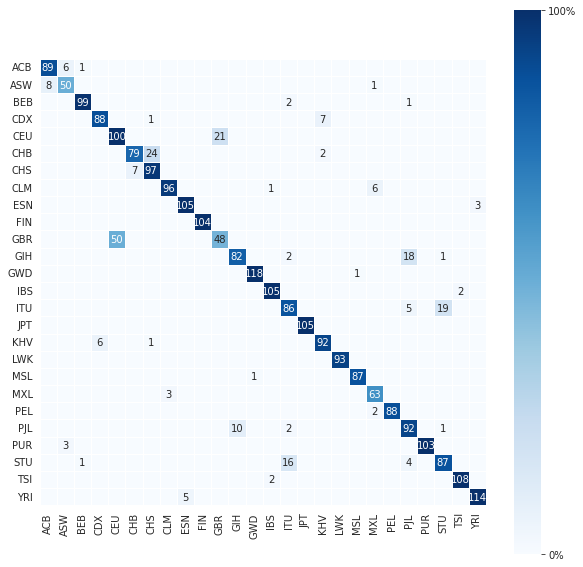

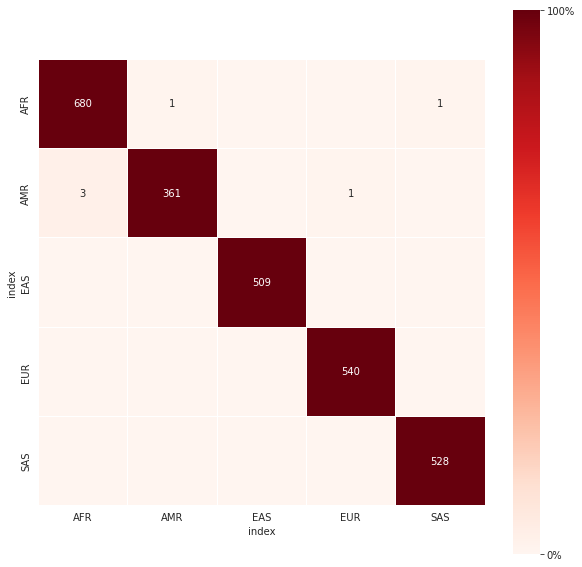

In [305]:
K = 5
kf = KFold(n_splits=K, shuffle=True)
cf_matrix = numpy.zeros((26, 26))
fold = 0
for train_index, test_index in kf.split(y):
    X_train, y_train = x_np[train_index], y_np[train_index]
    X_test, y_test = x_np[test_index], y_np[test_index]

    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)

    help_vector = list(range(26))
    ones_vector = numpy.diag(numpy.full(26,-1))
    cf_matrix_fold = confusion_matrix(y_test.tolist() + help_vector, predictions_test.tolist() + help_vector)
    cf_matrix_fold = cf_matrix_fold + ones_vector
    cf_matrix = cf_matrix + cf_matrix_fold
    fold += 1
#numpy.fill_diagonal(cf_matrix, 0)
make_confusion_matrix(cf_matrix.astype(int))


## Experiment 1
### How well random forest predicts suspicious samples without training on them
##### **Note: All values on heatmaps has been summarized across kfold runs.**

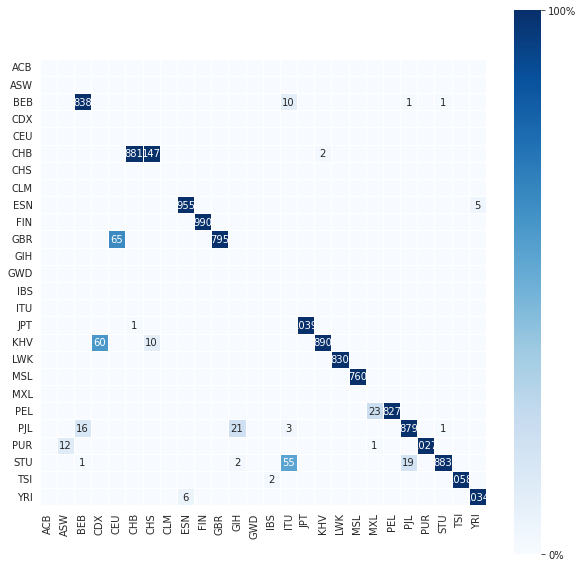

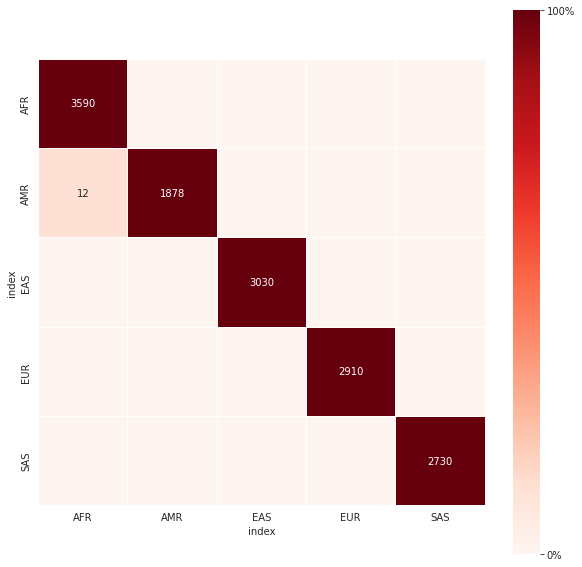

In [306]:
kf = KFold(n_splits=10, shuffle=True)
fold = 0
cf_matrix = numpy.zeros((26, 26))

for train_index, test_index in kf.split(samples_inverse):
    X_train, X_test = x_np[train_index], x_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    train_samples = [value for value in train_index if value in samples_index]
    test_samples = [value for value in test_index if value in samples_index]

    samples_x, samples_y = x_np[samples_inverse.index.values], y_np[samples_inverse.index.values]

    model.fit(X_train, y_train)
    predictions_samples = model.predict(samples_x)

    help_vector = list(range(26))
    ones_vector = numpy.diag(numpy.full(26,-1))
    cf_matrix_fold = confusion_matrix(samples_y.tolist() + help_vector, predictions_samples.tolist() + help_vector)
    cf_matrix_fold = cf_matrix_fold + ones_vector
    cf_matrix = cf_matrix + cf_matrix_fold
    fold += 1

#numpy.fill_diagonal(cf_matrix, 0)
make_confusion_matrix(cf_matrix.astype(int))

## Experiment 2
### How well random forest predicts 20%  of suspicious samples (+ all other samples in training set) with training using 80% of them (+ all other samples in test set)
##### **Note: All values on heatmaps has been summarized across kfold runs.**

In [307]:
def split_in_chunks(lst, n):
    random.shuffle(lst)
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def flatten_list(lst):
    return [item for sublist in lst for item in sublist]

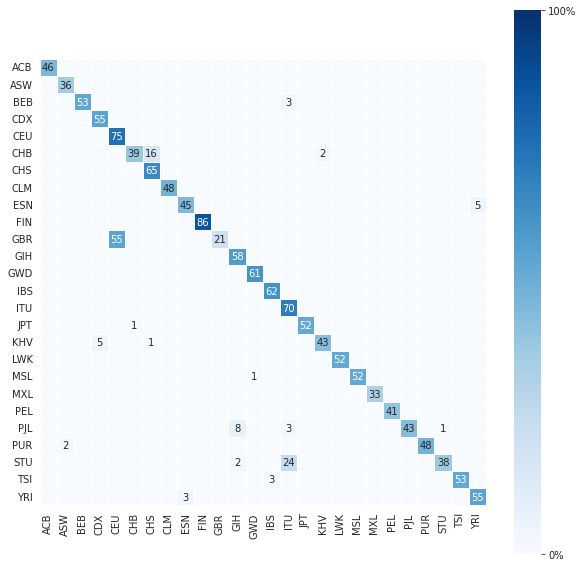

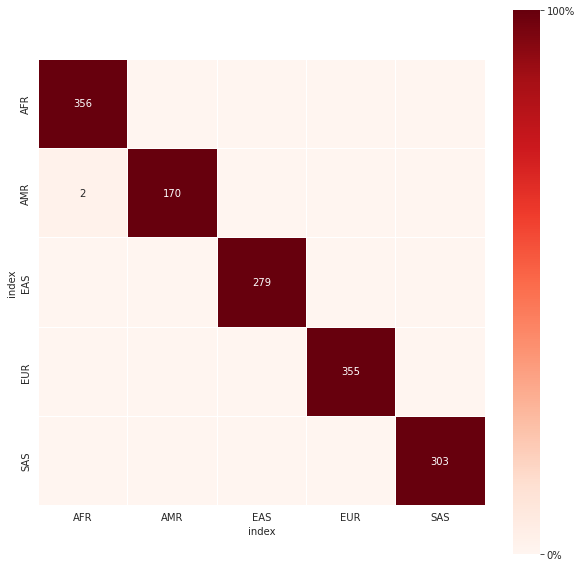

In [308]:
K = 5
kf = KFold(n_splits=K, shuffle=True)
cf_matrix = numpy.zeros((26, 26))
samples_index_chunks = list(split_in_chunks(samples_index, 10))

fold = 0
for train_index, test_index in kf.split(samples_inverse):

    train_index = list(train_index) + flatten_list(list(samples_index_chunks)[:fold]) + flatten_list(list(samples_index_chunks)[fold+1:])
    test_index = test_index.tolist() + samples_index_chunks[fold].tolist()

    X_train, y_train = x_np[train_index], y_np[train_index]
    X_test, y_test = x_np[test_index], y_np[test_index]

    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)

    help_vector = list(range(26))
    ones_vector = numpy.diag(numpy.full(26,-1))
    cf_matrix_fold = confusion_matrix(y_test.tolist() + help_vector, predictions_test.tolist() + help_vector)
    cf_matrix_fold = cf_matrix_fold + ones_vector
    cf_matrix = cf_matrix + cf_matrix_fold
    fold += 1

make_confusion_matrix(cf_matrix.astype(int))

## Experiment 3
### How well random forest predicts 20%  of suspicious samples with training using 80% of them
##### **Note: All values on heatmaps has been summarized across kfold runs.**

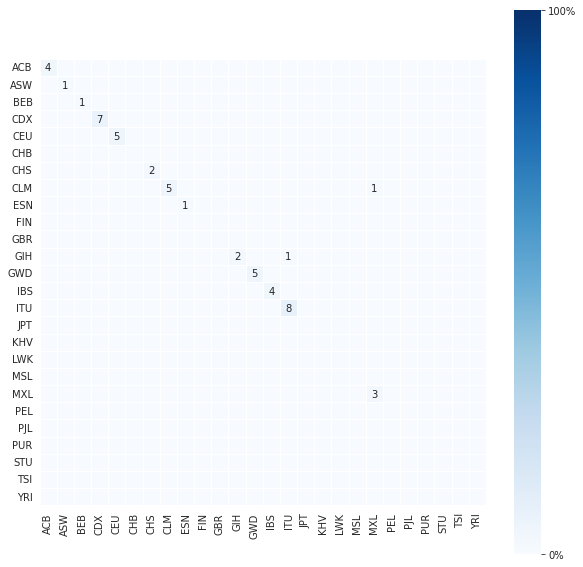

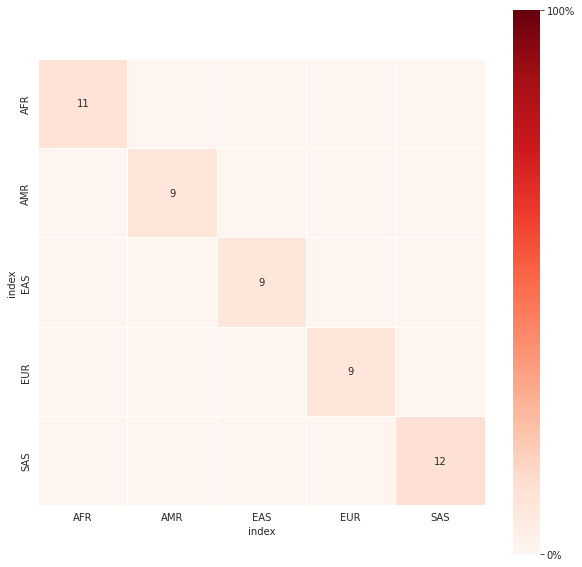

In [309]:
K = 5
kf = KFold(n_splits=K, shuffle=True)
cf_matrix = numpy.zeros((26, 26))
samples_index_chunks = list(split_in_chunks(samples_index, 10))

fold = 0
for train_index, test_index in kf.split(samples_inverse):

    train_index = flatten_list(list(samples_index_chunks)[:fold]) + flatten_list(list(samples_index_chunks)[fold+1:])
    test_index = samples_index_chunks[fold].tolist()

    X_train, y_train = x_np[train_index], y_np[train_index]
    X_test, y_test = x_np[test_index], y_np[test_index]

    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)

    help_vector = list(range(26))
    ones_vector = numpy.diag(numpy.full(26,-1))
    cf_matrix_fold = confusion_matrix(y_test.tolist() + help_vector, predictions_test.tolist() + help_vector)
    cf_matrix_fold = cf_matrix_fold + ones_vector
    cf_matrix = cf_matrix + cf_matrix_fold
    fold += 1

make_confusion_matrix(cf_matrix.astype(int))


## Experiment 4
### How well random forest predicts all other samples by training using suspicious samples only
##### **Note: All values on heatmaps has been summarized across kfold runs.**

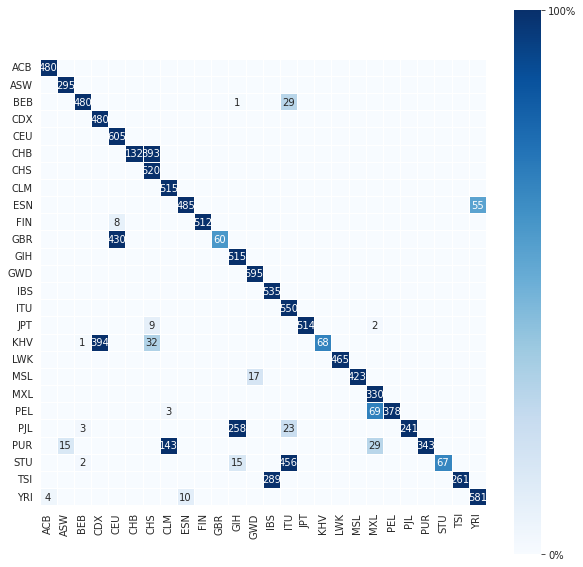

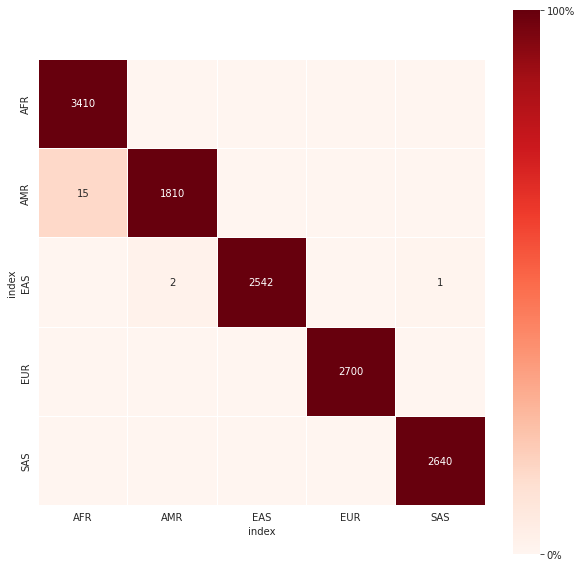

In [310]:
K = 5
kf = KFold(n_splits=K, shuffle=True)
cf_matrix = numpy.zeros((26, 26))
samples_index_chunks = list(split_in_chunks(samples_index, 10))

fold = 0
for train_index, test_index in kf.split(samples_inverse):

    train_index = flatten_list(list(samples_index_chunks))

    X_train, y_train = x_np[train_index], y_np[train_index]
    X_test, y_test = x_np, y_np

    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)

    help_vector = list(range(26))
    ones_vector = numpy.diag(numpy.full(26,-1))
    cf_matrix_fold = confusion_matrix(y_test.tolist() + help_vector, predictions_test.tolist() + help_vector)
    cf_matrix_fold = cf_matrix_fold + ones_vector
    cf_matrix = cf_matrix + cf_matrix_fold
    fold += 1

make_confusion_matrix(cf_matrix.astype(int))


# Conclusions
1. On the super population level most often AMR gets mistaken as AFR which can be explained by rich african american representation in North America.
2. On the population level most common errors are GBR are recognized as CEU, CHB as CHS and STU as ITU. These groups also share connections in some way with each other.
3. If we take a closer look below at what kind of samples where introduced in suspicious samples, we will find exactly the groups that are described above.


In [311]:
samples['pop'].value_counts()[:7]

CEU    121
GWD    119
ITU    110
IBS    107
CHS    104
GIH    103
CLM    103
Name: pop, dtype: int64

In [312]:
samples_inverse['ancestry'].value_counts()[:7]

TSI    106
PUR    104
YRI    104
JPT    104
CHB    103
FIN     99
KHV     96
Name: ancestry, dtype: int64